In [4]:
import MCMC as MCSZ
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import Mather_photonNEP12a as NEP

In [25]:
#Constants
c = 299792458.0                                         # Speed of light - [c] = m/s

#Specify parameter values

#Galaxy cluster parameters
y = 15e-6
electron_temperature = 5.0 #KeV
tau = MCSZ.y_to_tau(y,electron_temperature)
peculiar_vel = 1100 #km/s
betac = peculiar_vel/(3e5)

#SIDES model values
amp_sides = 1
b_sides = 1

#Specify which SIDES pixel to look at 
SIDES_longitude = 120
SIDES_latitude = 120

#CMB anisotropies values
amp_ksz = 6e-7
amp_tsz = 6e-7
amp_cmb = 1e-6

#Integration time

Time = 86400*40 #40 hours

labels = ('tau','temperature','betac','amp_sides','b_sides')
theta = (y, electron_temperature, betac, amp_sides, b_sides)
anisotropies = (amp_ksz, amp_tsz, amp_cmb)

In [26]:
def sigB(band_details, Time, Tnoise=3.0):
    #NESB values from the NEP and band definitions
    #Mode 0 specifies photometry
    #Mode 1 specifies spectrometry
    OE = 0.5
    scan_ineff = 0.1
    nu_min = band_details['nu_minGHz']*1E9 
    nu_max = band_details['nu_maxGHz']*1E9
    if (band_details['mode'] == 0):
        nu_vec = (nu_max + nu_min)/2.0
        del_nu = nu_max - nu_min
    if (band_details['mode'] == 1):
        nu_res = band_details['nu_resGHz']*1E9
        Nse = int(np.ceil((nu_max-nu_min)/nu_res))
        nu_vec = np.linspace(nu_min, nu_max, Nse) #in Hz
    NEP_phot = band_details['NEP']
    Npx = band_details['N_pixels']
    AOnu = (c/nu_vec)**2

    #NEP_phot1 = NEP.photonNEPdifflim(nu_min, nu_max, Tnoise) #This is CMB Tnoise
    #NEP_phot2 = NEP.photonNEPdifflim(nu_min, nu_max, 10.0, aef=0.01) #Use real south pole data
    #NEP_det = 1e-18 # ATTO WATTS per square-root(hz)
    #NEP_phot = np.sqrt(NEP_phot1**2 + NEP_det**2)
    
    if (NEP_phot<1E-18):
        print('Warning photon NEP is below 1 aW/rt.Hz!')
    elif (NEP_phot>1E-15):
        print('Warning photon NEP is above 1 fW/rt.Hz!')
       
    if (band_details['mode'] == 0):
        delP = NEP_phot/np.sqrt(Time*Npx)
        sigma_B = delP/(AOnu)/(del_nu*OE*scan_ineff)
    if (band_details['mode'] == 1):
        delP = 2*int(np.ceil(nu_max/nu_res))*NEP_phot/np.sqrt(Time*Npx)
        sigma_B = delP/(AOnu)/(nu_res*OE*scan_ineff)
       
    return nu_vec, sigma_B

In [27]:
freq = np.linspace(80e9,720e9,1000)
templates_emission_lines = MCSZ.data_indv(theta, anisotropies, freq, SIDES_longitude, SIDES_latitude)

/home/bolocam/erapaport/OLIMPO-forecasting/MCMC.py:99: RuntimeWarning: divide by zero encountered in log
  def interpolate(freq, datay, datax):


In [28]:
templates_continuum = MCSZ.model_indv(theta,anisotropies,freq)

In [29]:
#NEP definitions
NEP_1 = 7.3e-18
NEP_2 = 1.3e-17
NEP_3 = 7.5e-18
NEP_4 = 1.2e-17

#Pixel count definitions
pix1 = 23
pix2 = 39
pix3 = 25
pix4 = 43

#Resolution definitions (Spectrometry)
res1 = 29.0
res2 = 89.0
res3 = 49.0
res4 = 49.0

#Spectrometry bands
# Bands_list = [{'mode':1,'name':'Band 1','nu_minGHz':130,'nu_maxGHz':160,'nu_resGHz':res1,'N_pixels':pix1, 'NEP':NEP_1},\
#       {'mode':1,'name':'Band 2','nu_minGHz':190,'nu_maxGHz':280,'nu_resGHz':res2,'N_pixels':pix2, 'NEP':NEP_2},\
#       {'mode':1,'name':'Band 3','nu_minGHz':310,'nu_maxGHz':360,'nu_resGHz':res3,'N_pixels':pix3, 'NEP':NEP_3},\
#               {'mode':1,'name':'Band 4','nu_minGHz':420,'nu_maxGHz':470,'nu_resGHz':res4,'N_pixels':pix4, 'NEP':NEP_4}]

#Photometry bands
Bands_list = [{'mode':0,'name':'Band 1','nu_minGHz':133,'nu_maxGHz':159,'N_pixels':pix1,'NEP':NEP_1},\
     {'mode':0,'name':'Band 2','nu_minGHz':192,'nu_maxGHz':304,'N_pixels':pix2,'NEP':NEP_2},\
     {'mode':0,'name':'Band 3','nu_minGHz':330,'nu_maxGHz':362,'N_pixels':pix3,'NEP':NEP_3},\
             {'mode':0,'name':'Band 4','nu_minGHz':457,'nu_maxGHz':515,'N_pixels':pix4,'NEP':NEP_4}]


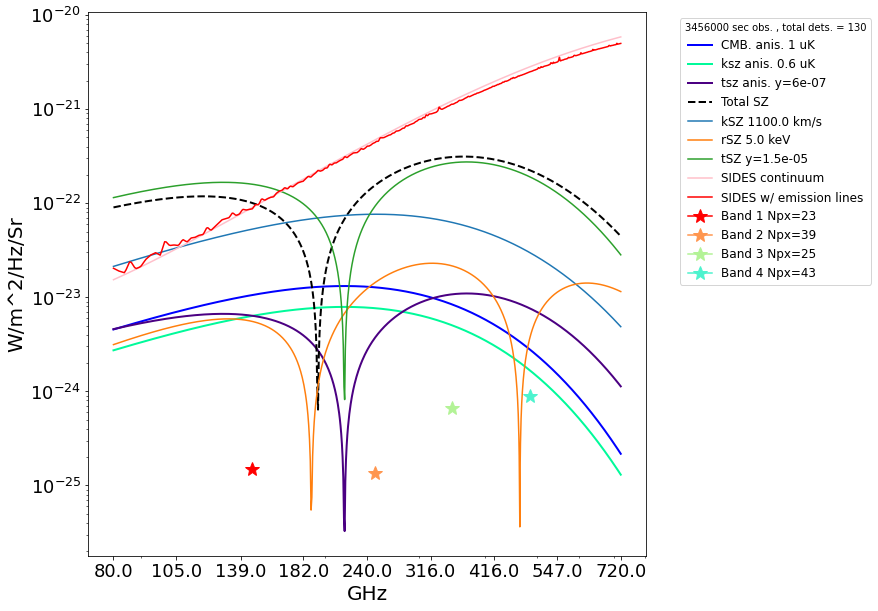

In [34]:
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
labs = ['SZ','CIB','CMB. anis. ' + str(round(amp_cmb*1e6)) + ' uK','ksz anis. ' + str(amp_ksz*1e6) + ' uK','tsz anis. y=' + str(amp_tsz)]
tempcolors = ['blue','mediumspringgreen','indigo','red','green','purple','magenta','black','violet','gray']
plt.figure(figsize=(10,10))

#Plot CMB, ksz, tsz, anisotropies
for i in range(len(templates_emission_lines)-2):
    plt.plot(freq*1e-9,abs(templates_emission_lines[i+2]),color=tempcolors[i],label=labs[i+2],linewidth=2)
    
#Plot SZ components
plt.plot(freq*1e-9,abs(templates_emission_lines[0]),'--k',label='Total SZ',linewidth=2)
plt.plot(freq*1e-9,abs(templates_emission_lines[0] - MCSZ.szpack_signal(freq,MCSZ.y_to_tau(y,electron_temperature),electron_temperature,1e-11)),\
         label='kSZ ' + str(betac*3e5) + ' km/s')
plt.plot(freq*1e-9,abs(MCSZ.szpack_signal(freq,MCSZ.y_to_tau(y,electron_temperature),electron_temperature,1e-11) - \
                  MCSZ.classical_tsz(y,freq)),label='rSZ ' + str(electron_temperature) + ' keV')
plt.plot(freq*1e-9,abs(MCSZ.classical_tsz(y,freq)),label='tSZ y=' + str(y))

#SIDES continuum model and emission line data
plt.plot(freq*1e-9,abs(templates_continuum[1]),color='pink',label='SIDES continuum')
plt.plot(freq*1e-9,abs(templates_emission_lines[1]),color='red',label='SIDES w/ emission lines')

#Plot frequency channel NESB
ncolor = len(Bands_list)
color=iter(cm.rainbow(np.linspace(1,0,ncolor+2)))
for bb in range(ncolor):
    b = Bands_list[bb]
    nu_vec_b, sigma_B_b = sigB(b, Time)
    colr=next(color)
    plt.plot(nu_vec_b*1e-9, sigma_B_b, label=b['name'] +' Npx='+str(b['N_pixels']), marker='*',ms=15, color=colr) #lw=5, alpha=0.8

plt.xscale('log')
plt.yscale('log')
#plt.xlim([80, 720])
#plt.ylim(1E-27, 2E-20)
plt.xlabel('GHz',fontsize=20)
plt.ylabel('W/m^2/Hz/Sr',fontsize=20)

#Make xticks match as best as possible
plt.xticks(np.rint(np.logspace(np.log10(80), np.log10(7.2e2),num=9)),np.rint(np.logspace(np.log10(80), np.log10(7.2e2),num=9)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',\
           frameon=True, prop={'size':12}, ncol=1, title= str(Time) + ' sec obs. , total dets. = '+str(pix1+pix2+pix3+pix4))
plt.show()